> ## ⚠️ Important Lab Disclaimer
> This lab requires API keys (OpenAI, Tavily, OpenWeather) if you want to run the live examples.  
> These keys stay only inside the **temporary Udemy lab workspace** and are **not persisted or shared**, but you should still treat them like any other secret.  
> Use your own discretion when entering keys, and feel free to **revoke or rotate** them after the lab.  
> If you prefer **not** to use real API keys, Copy paste away or download the notebook and run it locally.


This script securely collect API key (`OPENAI_API_KEY`) using `getpass` so your input is hidden.  
It then creates/overwrites a `.env` file and writes each key as `NAME=value` on its own line.  
Finally, it prints **“Saved .env”** when finished.


In [ ]:
from getpass import getpass

names = ["OPENAI_API_KEY"]
with open(".env", "w", encoding="utf-8") as f:
    for n in names:
        f.write(f"{n}={getpass(f'Enter {n}: ').strip()}\n")
print("Saved .env")


This code locates the nearest `.env` file in the current working directory (using `find_dotenv`) and loads its key–value pairs into the environment (using `load_dotenv`).  
It does **not** overwrite any existing environment variables because `override=False`.


In [ ]:
from dotenv import load_dotenv, find_dotenv
env_path = find_dotenv(usecwd=True)
load_dotenv(env_path, override=False)

In [2]:
# Standard library
import json
import operator
from typing import Optional, Literal, List, Annotated
from typing_extensions import TypedDict

# Third-party
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langchain_openai import ChatOpenAI

# LangGraph
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command, Send



### **ChatInput**
Captures the user’s raw travel request so the system knows what to interpret.

### **TripOutput**
Holds the final itinerary plus the user’s decision to **approve** or **edit**, along with any edit notes.

### **TripWS**
The workflow’s internal state: last message, extracted trip details, preferences, generated itinerary, and HITL decision. It keeps everything aligned as the conversation progresses.


### **LLM Setup**
A low-temperature model is used to keep outputs stable and deterministic for field extraction.

### **Required Field Check**
The helper `has_all_required()` confirms the two essentials — **party_size** and **days** — are present before itinerary generation continues.

### **Extraction System Prompt**
Defines the rule:  
Convert the user’s message into **strict JSON**, avoid guessing, and never add commentary.

### **Extraction Format Template**
Specifies the exact JSON structure the LLM must return, including:
- Required numeric fields (party size, days)  
- Optional preferences (interests, pace, dietary, mobility, start location, must-sees)  
- Clear guidelines on how to treat missing or implied information  

### `extract_fields_from_text(prompt_text)`
Turns a free-text trip request into a **clean dict of fields** (party_size, days, interests, etc.) using the extraction prompt and JSON schema.

### `clarify(state)`
If required fields are missing, it asks the LLM to write **short, focused follow-up questions**, sends them to the user via `interrupt`, and saves the user’s reply back as `prompt`.

### `sketch(state)`
Merges newly extracted fields into the working state.  
- If required fields are still missing → returns partial updates so the graph can go back to **clarify**.  
- If all required fields are present → uses the LLM to generate a **compact day-by-day NYC itinerary** (JSON) and returns an updated `TripWS`.

### `review(state)`
Triggers **human review** of the itinerary via `interrupt`.  
- If the user sends edits → marks `decision = "edit"` and updates `itinerary`/`edits`.  
- Otherwise → treats it as `decision = "approve"`.

### `publish(state)`
Converts the working state into the final **TripOutput** object with `itinerary`, `decision`, and optional `edits` for the UI or caller.

### `route_after_sketch(state)`
Simple router after `sketch`:
- Missing required fields → `"clarify"`.
- Itinerary present → `"review"`.
Keeps the loop tight: **clarify → sketch → review → publish**.

### Graph
A typed LangGraph pipeline where:
- **sketch** drafts the plan or detects missing info  
- **clarify** collects required details  
- **review** gets human approval/edits  
- **publish** outputs the final itinerary

Routing keeps looping `clarify ↔ sketch` until ready, then moves to `review → publish`.  
`MemorySaver` preserves state across turns.

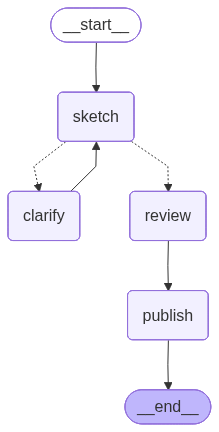

In [4]:
class ChatInput(BaseModel):
    prompt: str = Field(..., description="Plain-text user request (free form)")

class TripOutput(BaseModel):
    itinerary: str
    decision: Literal["approve","edit"]
    edits: Optional[str] = None

class TripWS(TypedDict, total=False):
    # Conversation memory
    prompt: str                    # last user message (plain text)
    # Extracted fields (required)
    party_size: int
    days: int
    # Optional prefs (extendable)
    interests: List[str]
    pace: str
    dietary: List[str]
    mobility: str
    start_location: str
    must_sees: List[str]
    # Generated
    itinerary: str
    # HITL capture
    decision: Literal["approve","edit"]
    edits: Optional[str]

llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0.2)
REQUIRED_FIELDS = ("party_size", "days")

def has_all_required(state: TripWS) -> bool:
    return all(k in state and state[k] not in (None, "", 0) for k in REQUIRED_FIELDS)    

EXTRACTION_SYS = (
    "You convert a plain-English NYC trip request into STRICT JSON fields. "
    "If a field is unknown, use null (not a guess). "
    "Return ONLY JSON. Do not add commentary."
)

EXTRACTION_FORMAT = """
Return JSON with exactly these keys:
{
  "party_size": int|null,
  "days": int|null,
  "interests": string[]|null,
  "pace": "easy"|"moderate"|"packed"|null,
  "dietary": string[]|null,
  "mobility": "no-constraints"|"stroller"|"limited-walking"|"wheelchair"|null,
  "start_location": string|null,
  "must_sees": string[]|null
}
Guidelines:
- party_size is an integer (adults+kids total) if stated; else null.
- days is an integer (whole number); else null.
- If the user says “family” or “kids”, include "kids" in interests.
- If not specified, set mobility to null (not "no-constraints").
"""

def extract_fields_from_text(prompt_text: str) -> dict:
    if not prompt_text:
        return {}
    resp = llm.invoke([
        {"role":"system","content":EXTRACTION_SYS},
        {"role":"user","content":f"{EXTRACTION_FORMAT}\n\nUSER:\n{prompt_text}"}
    ]).content
    try:
        data = json.loads(resp)
    except json.JSONDecodeError:
        data = {}
    def _norm_list(v):
        return [x for x in v] if isinstance(v, list) else None
    return {
        "party_size": data.get("party_size"),
        "days": data.get("days"),
        "interests": _norm_list(data.get("interests")),
        "pace": data.get("pace"),
        "dietary": _norm_list(data.get("dietary")),
        "mobility": data.get("mobility"),
        "start_location": data.get("start_location"),
        "must_sees": _norm_list(data.get("must_sees")),
    }

def clarify(state: TripWS) -> TripWS:
    missing = [k for k in REQUIRED_FIELDS if not (state.get(k) not in (None, "", 0, [], {}))]
    
    if not missing:
        missing = [k for k in REQUIRED_FIELDS if k not in state]

    system = (
        "You are a friendly NYC trip-planning assistant. "
        "Ask ONLY the missing required fields as short, separate lines. "
        "Do not ask about optional preferences unless the user mentions them."
    )
    user = (
        f"Missing required fields: {', '.join(missing)}.\n"
        "Write one short question per line. Keep it NYC-contextual but concise."
    )
    followups = llm.invoke(
        [{"role":"system","content":system},{"role":"user","content":user}]
    ).content.strip()

    payload = {
        "message": "I need a quick detail to start your NYC plan.",
        "questions": followups,
        "how_to_resume": (
            "Reply in plain English (e.g., 'We're two adults for 3 days'). "
            "I’ll parse it automatically—no JSON needed."
        ),
    }
    human_text = interrupt(payload)  
    
    return {"prompt": str(human_text)}

def sketch(state: TripWS) -> TripWS | Command[TripWS]:
    
    raw_prompt = state.get("prompt", "") or ""
    extracted = extract_fields_from_text(raw_prompt) if raw_prompt else {}

    updates: TripWS = {}
    for k, v in extracted.items():
        if v not in (None, "", []):
            updates[k] = v

    merged = dict(state)
    merged.update(updates)
    if not has_all_required(merged):
        return updates  

    def _get(key, default=None):
        return merged.get(key, default)

    def _fmt_list(v):
        return ", ".join(v) if isinstance(v, list) else (v or "none")

    sys_prompt = (
        "You are an expert NYC planner. Create a compact, realistic itinerary with Day 1..N, "
        "organized by morning/afternoon/evening blocks. Assume subway/bus/walking; add brief transit hints. "
        "Respect optional preferences if given (interests, pace, dietary, mobility, start location, must-sees). "
        "NYC-wide by default (all boroughs). Include nearby side-trips only if asked or if it clearly aligns. "
        "Include 1–2 dining ideas per day. Return ONLY JSON."
    )

    user_prompt = f"""
        Trip facts (final):
        - Party size: {_get('party_size')}
        - Total days: {_get('days')}
        - Interests: {_fmt_list(_get('interests'))}
        - Pace: {_get('pace','none')}
        - Dietary: {_fmt_list(_get('dietary'))}
        - Mobility: {_get('mobility','no-constraints')}
        - Start location: {_get('start_location','unspecified')}
        - Must-sees: {_fmt_list(_get('must_sees'))}

        Output STRICT JSON with exactly:
        {{ "itinerary": "string with Day 1..N sections, bullets for morning/afternoon/evening, brief transit hints, and 1–2 dining ideas/day" }}

        Rules:
        - Keep each day concise (5–8 bullets total).
        - Cluster geographically to reduce backtracking.
        - Include at least one cross-borough highlight across the trip (time permitting).
        - If 'kids' in interests or party_size >= 3, bias family-friendly options.
        - If mobility constraints exist, note accessible routes/alternatives.
        - Return ONLY JSON.
    """
    resp = llm.invoke(
        [{"role":"system","content":sys_prompt},{"role":"user","content":user_prompt}]
    ).content

    try:
        data = json.loads(resp)
    except json.JSONDecodeError:
        data = {"itinerary": resp}

    final: TripWS = {
        "itinerary": data.get("itinerary", "NYC plan forthcoming."),
        "party_size": _get("party_size"),
        "days": _get("days"),
    }
    for opt in ("interests","pace","dietary","mobility","start_location","must_sees","prompt"):
        if _get(opt) not in (None, "", []):
            final[opt] = _get(opt)
    return final

def review(state: TripWS) -> TripWS:
    payload = {
        "message": "Review itinerary and approve or provide edits.",
        "proposal": state["itinerary"],
        "how_to_resume": (
            "Reply in plain English, e.g., 'approve' OR 'edit: <your revised text>'."
        )
    }
    import sys
    print("\n=== HUMAN REVIEW REQUIRED ===", file=sys.stdout)
    print(json.dumps(payload, indent=2), file=sys.stdout)

    human_text = interrupt(payload)  
    text = str(human_text).strip().lower()

    updates: TripWS = {}
    if text.startswith("edit:"):
        updates["decision"] = "edit"
        raw_edit = str(human_text)[5:].strip()
        updates["edits"] = raw_edit or None
        if raw_edit:
            updates["itinerary"] = raw_edit
    elif text == "approve" or "approve" in text:
        updates["decision"] = "approve"
    else:
        updates["decision"] = "approve"
    return updates

def publish(state: TripWS) -> TripOutput:
    return TripOutput(
        itinerary=state["itinerary"],
        decision=state.get("decision", "approve"),
        edits=state.get("edits")
    )

def route_after_sketch(state: TripWS) -> str:
    
    if not has_all_required(state):
        return "clarify"
    
    if "itinerary" in state and state["itinerary"]:
        return "review"
    
    return "clarify"


g = StateGraph(TripWS, input_schema=ChatInput, output_schema=TripOutput)
g.add_node("sketch", sketch)        
g.add_node("clarify", clarify)      
g.add_node("review", review)
g.add_node("publish", publish)

g.add_edge(START, "sketch")
g.add_conditional_edges("sketch", route_after_sketch, {"clarify": "clarify", "review": "review"})
g.add_edge("clarify", "sketch")    
g.add_edge("review", "publish")
g.add_edge("publish", END)

memory = MemorySaver()    
app = g.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

A thread-specific config is created, then the app is invoked with a user prompt.  
Because required fields (`party_size`, `days`) are missing, the graph routes to **clarify**, triggering short follow-up questions to collect those details.


In [5]:
cfg = {"configurable": {"thread_id": "nyc-demo-1"}}
# 1) Missing requireds → follow-ups
app.invoke({"prompt": "Planning NYC soon. We love museums and pizza."}, config=cfg)


{'__interrupt__': [Interrupt(value={'message': 'I need a quick detail to start your NYC plan.', 'questions': 'What is the size of your party?  \nHow many days will you be staying in NYC?', 'how_to_resume': "Reply in plain English (e.g., 'We're two adults for 3 days'). I’ll parse it automatically—no JSON needed."}, id='bd4686c02e5ddc7a1f35cf1392e83d41')]}

The user answers the follow-up questions using `Command(resume=...)`.  
This supplies the missing required fields, allowing the graph to continue past **clarify** and move into the itinerary-generation step.

In [6]:
# (You’ll see an interrupt asking for party_size and/or days)
app.invoke(Command(resume="We are two adults for 3 days."), config=cfg)


=== HUMAN REVIEW REQUIRED ===
{
  "message": "Review itinerary and approve or provide edits.",
  "proposal": "Day 1: Morning - Visit the Metropolitan Museum of Art on the Upper East Side. Afternoon - Enjoy a slice of classic New York pizza at Joe's Pizza in Greenwich Village. Evening - Stroll through Central Park and have dinner at The Loeb Boathouse. Day 2: Morning - Explore the Museum of Modern Art (MoMA) in Midtown. Afternoon - Grab a delicious pizza at Juliana's in Brooklyn. Evening - Walk across the Brooklyn Bridge and have dinner at Grimaldi's Pizzeria. Day 3: Morning - Visit the American Museum of Natural History on the Upper West Side. Afternoon - Indulge in a unique pizza experience at Roberta's in Brooklyn. Evening - Take a leisurely walk along the High Line and have dinner at Chelsea Market.",
  "how_to_resume": "Reply in plain English, e.g., 'approve' OR 'edit: <your revised text>'."
}


{'itinerary': "Day 1: Morning - Visit the Metropolitan Museum of Art on the Upper East Side. Afternoon - Enjoy a slice of classic New York pizza at Joe's Pizza in Greenwich Village. Evening - Stroll through Central Park and have dinner at The Loeb Boathouse. Day 2: Morning - Explore the Museum of Modern Art (MoMA) in Midtown. Afternoon - Grab a delicious pizza at Juliana's in Brooklyn. Evening - Walk across the Brooklyn Bridge and have dinner at Grimaldi's Pizzeria. Day 3: Morning - Visit the American Museum of Natural History on the Upper West Side. Afternoon - Indulge in a unique pizza experience at Roberta's in Brooklyn. Evening - Take a leisurely walk along the High Line and have dinner at Chelsea Market.",
 '__interrupt__': [Interrupt(value={'message': 'Review itinerary and approve or provide edits.', 'proposal': "Day 1: Morning - Visit the Metropolitan Museum of Art on the Upper East Side. Afternoon - Enjoy a slice of classic New York pizza at Joe's Pizza in Greenwich Village. Ev

After the draft itinerary is shown, the user replies with `Command(resume="approve")`.  
The review step records this approval and the graph moves to **publish**, returning the final confirmed itinerary.

In [7]:
# (Itinerary generated → review interrupt)
app.invoke(Command(resume="approve"), config=cfg)


=== HUMAN REVIEW REQUIRED ===
{
  "message": "Review itinerary and approve or provide edits.",
  "proposal": "Day 1: Morning - Visit the Metropolitan Museum of Art on the Upper East Side. Afternoon - Enjoy a slice of classic New York pizza at Joe's Pizza in Greenwich Village. Evening - Stroll through Central Park and have dinner at The Loeb Boathouse. Day 2: Morning - Explore the Museum of Modern Art (MoMA) in Midtown. Afternoon - Grab a delicious pizza at Juliana's in Brooklyn. Evening - Walk across the Brooklyn Bridge and have dinner at Grimaldi's Pizzeria. Day 3: Morning - Visit the American Museum of Natural History on the Upper West Side. Afternoon - Indulge in a unique pizza experience at Roberta's in Brooklyn. Evening - Take a leisurely walk along the High Line and have dinner at Chelsea Market.",
  "how_to_resume": "Reply in plain English, e.g., 'approve' OR 'edit: <your revised text>'."
}


{'itinerary': "Day 1: Morning - Visit the Metropolitan Museum of Art on the Upper East Side. Afternoon - Enjoy a slice of classic New York pizza at Joe's Pizza in Greenwich Village. Evening - Stroll through Central Park and have dinner at The Loeb Boathouse. Day 2: Morning - Explore the Museum of Modern Art (MoMA) in Midtown. Afternoon - Grab a delicious pizza at Juliana's in Brooklyn. Evening - Walk across the Brooklyn Bridge and have dinner at Grimaldi's Pizzeria. Day 3: Morning - Visit the American Museum of Natural History on the Upper West Side. Afternoon - Indulge in a unique pizza experience at Roberta's in Brooklyn. Evening - Take a leisurely walk along the High Line and have dinner at Chelsea Market.",
 'decision': 'approve',
 'edits': None}

Here the user provides all required details in a single prompt (party size, days, preferences).  
Because nothing is missing, the graph skips **clarify**, goes straight to **sketch** to generate the itinerary, and then into **review** for human approval or edits.

In [8]:
# 2) Everything in one go → straight to itinerary, then review
cfg = {"configurable": {"thread_id": "nyc-plain-2"}}

app.invoke({"prompt": "Family of 5 for 3 days. Kids love ferries and Central Park. Vegetarian food preferred."}, config=cfg)


=== HUMAN REVIEW REQUIRED ===
{
  "message": "Review itinerary and approve or provide edits.",
  "proposal": "Day 1: Morning - Take the Staten Island Ferry for great views of the Statue of Liberty (accessible route available). Afternoon - Explore Central Park, visit the Central Park Zoo for the kids. Evening - Enjoy a vegetarian dinner at Candle 79, a popular upscale vegan restaurant. Day 2: Morning - Visit the Children's Museum of Manhattan for interactive exhibits. Afternoon - Take a walk on the High Line, an elevated park with beautiful views. Evening - Have dinner at Blossom on Columbus, offering a variety of vegetarian dishes. Day 3: Morning - Head to Brooklyn Bridge Park for a ferry ride on the East River Ferry. Afternoon - Visit the Brooklyn Children's Museum for more kid-friendly activities. Evening - Conclude your trip with a vegetarian dinner at Modern Love Brooklyn, known for its delicious plant-based comfort food.",
  "how_to_resume": "Reply in plain English, e.g., 'approv

{'itinerary': "Day 1: Morning - Take the Staten Island Ferry for great views of the Statue of Liberty (accessible route available). Afternoon - Explore Central Park, visit the Central Park Zoo for the kids. Evening - Enjoy a vegetarian dinner at Candle 79, a popular upscale vegan restaurant. Day 2: Morning - Visit the Children's Museum of Manhattan for interactive exhibits. Afternoon - Take a walk on the High Line, an elevated park with beautiful views. Evening - Have dinner at Blossom on Columbus, offering a variety of vegetarian dishes. Day 3: Morning - Head to Brooklyn Bridge Park for a ferry ride on the East River Ferry. Afternoon - Visit the Brooklyn Children's Museum for more kid-friendly activities. Evening - Conclude your trip with a vegetarian dinner at Modern Love Brooklyn, known for its delicious plant-based comfort food.",
 '__interrupt__': [Interrupt(value={'message': 'Review itinerary and approve or provide edits.', 'proposal': "Day 1: Morning - Take the Staten Island Fer

In this one-shot scenario, `Command(resume="approve")` confirms the generated itinerary without edits.  
The review step records the approval and the graph immediately runs **publish**, returning the final family itinerary.

In [9]:
app.invoke(Command(resume="approve"), config=cfg)


=== HUMAN REVIEW REQUIRED ===
{
  "message": "Review itinerary and approve or provide edits.",
  "proposal": "Day 1: Morning - Take the Staten Island Ferry for great views of the Statue of Liberty (accessible route available). Afternoon - Explore Central Park, visit the Central Park Zoo for the kids. Evening - Enjoy a vegetarian dinner at Candle 79, a popular upscale vegan restaurant. Day 2: Morning - Visit the Children's Museum of Manhattan for interactive exhibits. Afternoon - Take a walk on the High Line, an elevated park with beautiful views. Evening - Have dinner at Blossom on Columbus, offering a variety of vegetarian dishes. Day 3: Morning - Head to Brooklyn Bridge Park for a ferry ride on the East River Ferry. Afternoon - Visit the Brooklyn Children's Museum for more kid-friendly activities. Evening - Conclude your trip with a vegetarian dinner at Modern Love Brooklyn, known for its delicious plant-based comfort food.",
  "how_to_resume": "Reply in plain English, e.g., 'approv

{'itinerary': "Day 1: Morning - Take the Staten Island Ferry for great views of the Statue of Liberty (accessible route available). Afternoon - Explore Central Park, visit the Central Park Zoo for the kids. Evening - Enjoy a vegetarian dinner at Candle 79, a popular upscale vegan restaurant. Day 2: Morning - Visit the Children's Museum of Manhattan for interactive exhibits. Afternoon - Take a walk on the High Line, an elevated park with beautiful views. Evening - Have dinner at Blossom on Columbus, offering a variety of vegetarian dishes. Day 3: Morning - Head to Brooklyn Bridge Park for a ferry ride on the East River Ferry. Afternoon - Visit the Brooklyn Children's Museum for more kid-friendly activities. Evening - Conclude your trip with a vegetarian dinner at Modern Love Brooklyn, known for its delicious plant-based comfort food.",
 'decision': 'approve',
 'edits': None}

A new thread is started with all required details in one prompt (2 adults, 2 days, Times Square, packed pace, MoMA).  
Since nothing is missing, the graph skips **clarify**, has **sketch** generate a packed 2-day itinerary, then moves into **review**, where the user can approve or request edits.


In [10]:
# 3) Exercise the edit path at review (still plain text)
cfg = {"configurable": {"thread_id": "nyc-plain-3"}}

app.invoke({"prompt": "Two adults for 2 days near Times Square. Pace packed. Must-see: MoMA."}, config=cfg)


=== HUMAN REVIEW REQUIRED ===
{
  "message": "Review itinerary and approve or provide edits.",
  "proposal": "Day 1: Morning: Visit MoMA (transit: walk). Afternoon: Explore Central Park, visit Central Park Zoo (transit: walk). Evening: Times Square lights, dinner at Ellen's Stardust Diner.",
  "how_to_resume": "Reply in plain English, e.g., 'approve' OR 'edit: <your revised text>'."
}


{'itinerary': "Day 1: Morning: Visit MoMA (transit: walk). Afternoon: Explore Central Park, visit Central Park Zoo (transit: walk). Evening: Times Square lights, dinner at Ellen's Stardust Diner.",
 '__interrupt__': [Interrupt(value={'message': 'Review itinerary and approve or provide edits.', 'proposal': "Day 1: Morning: Visit MoMA (transit: walk). Afternoon: Explore Central Park, visit Central Park Zoo (transit: walk). Evening: Times Square lights, dinner at Ellen's Stardust Diner.", 'how_to_resume': "Reply in plain English, e.g., 'approve' OR 'edit: <your revised text>'."}, id='e3de2498e74f74bfdaacb9d86c0f909e')]}

The user provides revised text using `Command(resume="edit: …")`.  
The review step marks the decision as **edit**, replaces the itinerary with the user’s version, and then continues to **publish** with the updated plan.

In [11]:
app.invoke(Command(resume="edit: Day 1: MoMA → Rockefeller → Bryant Park. Day 2: Central Park → AMNH → UWS dinner."), config=cfg)


=== HUMAN REVIEW REQUIRED ===
{
  "message": "Review itinerary and approve or provide edits.",
  "proposal": "Day 1: Morning: Visit MoMA (transit: walk). Afternoon: Explore Central Park, visit Central Park Zoo (transit: walk). Evening: Times Square lights, dinner at Ellen's Stardust Diner.",
  "how_to_resume": "Reply in plain English, e.g., 'approve' OR 'edit: <your revised text>'."
}


{'itinerary': 'Day 1: MoMA → Rockefeller → Bryant Park. Day 2: Central Park → AMNH → UWS dinner.',
 'decision': 'edit',
 'edits': 'Day 1: MoMA → Rockefeller → Bryant Park. Day 2: Central Park → AMNH → UWS dinner.'}

With `Command(resume="approve")`, the user confirms their edited itinerary.  
The review step records the approval, and the graph moves directly to **publish**, returning the finalized plan.


In [12]:
app.invoke(Command(resume="approve"), config=cfg)

{'itinerary': 'Day 1: MoMA → Rockefeller → Bryant Park. Day 2: Central Park → AMNH → UWS dinner.',
 'decision': 'edit',
 'edits': 'Day 1: MoMA → Rockefeller → Bryant Park. Day 2: Central Park → AMNH → UWS dinner.'}

This prompt is too vague and missing both required fields (party size is implied but days is unknown).  
The graph immediately routes to **clarify**, asking short follow-up questions to collect the missing trip details before any itinerary can be generated.


In [13]:
# 4) Exercise the edit path at review (still plain text)
cfg = {"configurable": {"thread_id": "nyc-plain-4"}}

app.invoke({"prompt": "Two adults in  nyc"}, config=cfg)

{'__interrupt__': [Interrupt(value={'message': 'I need a quick detail to start your NYC plan.', 'questions': 'How many days will you be staying in NYC?', 'how_to_resume': "Reply in plain English (e.g., 'We're two adults for 3 days'). I’ll parse it automatically—no JSON needed."}, id='a18df8463699c721a39811613807db5b')]}

The user replies with the missing details via `Command(resume=...)`.  
This fills in the required fields, allowing the graph to exit **clarify** and move forward to generate the itinerary in the **sketch** step.


In [14]:
app.invoke(Command(resume="'We're two adults for 3 days'"), config=cfg)


=== HUMAN REVIEW REQUIRED ===
{
  "message": "Review itinerary and approve or provide edits.",
  "proposal": "Day 1: Morning - Visit Central Park, enjoy a leisurely walk around the park. Transit: Subway to 59 St-Columbus Circle. Afternoon - Explore the Museum of Modern Art (MoMA) for world-class art collections. Transit: Short walk from Central Park. Dining: The Modern for a fine dining experience. Evening - Stroll along Fifth Avenue for window shopping and people-watching. Dining: Serafina for delicious Italian cuisine.",
  "how_to_resume": "Reply in plain English, e.g., 'approve' OR 'edit: <your revised text>'."
}


{'itinerary': 'Day 1: Morning - Visit Central Park, enjoy a leisurely walk around the park. Transit: Subway to 59 St-Columbus Circle. Afternoon - Explore the Museum of Modern Art (MoMA) for world-class art collections. Transit: Short walk from Central Park. Dining: The Modern for a fine dining experience. Evening - Stroll along Fifth Avenue for window shopping and people-watching. Dining: Serafina for delicious Italian cuisine.',
 '__interrupt__': [Interrupt(value={'message': 'Review itinerary and approve or provide edits.', 'proposal': 'Day 1: Morning - Visit Central Park, enjoy a leisurely walk around the park. Transit: Subway to 59 St-Columbus Circle. Afternoon - Explore the Museum of Modern Art (MoMA) for world-class art collections. Transit: Short walk from Central Park. Dining: The Modern for a fine dining experience. Evening - Stroll along Fifth Avenue for window shopping and people-watching. Dining: Serafina for delicious Italian cuisine.', 'how_to_resume': "Reply in plain Engl

After the itinerary is generated from the clarified details, the user sends `Command(resume="approve")`.  
The review step records the approval and the graph flows directly to **publish**, completing the trip plan.


In [15]:
app.invoke(Command(resume="approve"), config=cfg)


=== HUMAN REVIEW REQUIRED ===
{
  "message": "Review itinerary and approve or provide edits.",
  "proposal": "Day 1: Morning - Visit Central Park, enjoy a leisurely walk around the park. Transit: Subway to 59 St-Columbus Circle. Afternoon - Explore the Museum of Modern Art (MoMA) for world-class art collections. Transit: Short walk from Central Park. Dining: The Modern for a fine dining experience. Evening - Stroll along Fifth Avenue for window shopping and people-watching. Dining: Serafina for delicious Italian cuisine.",
  "how_to_resume": "Reply in plain English, e.g., 'approve' OR 'edit: <your revised text>'."
}


{'itinerary': 'Day 1: Morning - Visit Central Park, enjoy a leisurely walk around the park. Transit: Subway to 59 St-Columbus Circle. Afternoon - Explore the Museum of Modern Art (MoMA) for world-class art collections. Transit: Short walk from Central Park. Dining: The Modern for a fine dining experience. Evening - Stroll along Fifth Avenue for window shopping and people-watching. Dining: Serafina for delicious Italian cuisine.',
 'decision': 'approve',
 'edits': None}

## Multi-Idea NYC Trip Generator — What This Graph Does

- **Model + Prompts**
  - Uses `ChatOpenAI(gpt-3.5-turbo-0125, temperature=0)` for stable outputs.
  - First prompt (`trip_ideas_prompt`) asks for **exactly 3 short trip ideas** for a given `trip_type` and `days`.
  - Second prompt (`trip_generation_prompt`) asks for a **tight morning/afternoon/evening plan** for a single idea.

- **Structured Outputs**
  - `TripIdeas` model: `ideas: list[str]` → LLM must return a list of idea titles.
  - `Trip` model: `plan: str` → LLM must return a single concise plan.
  - Both nodes use `model.with_structured_output(...)` so the responses are parsed into these schemas.

- **State Shapes**
  - `OverallState` holds:
    - `trip_type` (e.g. `"family"`, `"couple"`)
    - `days` (e.g. `2`)
    - `trip_ideas` (filled by `generate_trip_ideas`)
    - `trips` as an **accumulating list** (thanks to `Annotated[list, operator.add]`).
  - `TripState` is per-idea: `{ "idea": ..., "trip_type": ... }`.

- **Nodes**
  - `generate_trip_ideas(state)`:
    - Calls the first prompt, gets a `TripIdeas` object.
    - Returns `{"trip_ideas": resp.ideas}` into `OverallState`.
  - `generate_trip(state)`:
    - Uses one `idea` + `trip_type` to call the second prompt.
    - Returns `{"trips": [ "<idea>\n<plan>" ]}` so each call appends one entry to the `trips` list.

- **Fan-Out Logic**
  - `continue_to_trips(state)` creates a list of `Send(...)` instructions:
    - One `Send("generate_trip", {...})` **per idea** in `trip_ideas`.
    - This tells LangGraph to run `generate_trip` once for each idea.

- **Graph Wiring**
  - `START → generate_trip_ideas`
  - From `generate_trip_ideas`, `add_conditional_edges(..., continue_to_trips, ["generate_trip"])`:
    - Fans out into multiple `generate_trip` calls (one per idea).
  - `generate_trip → END`
    - Each branch ends, and all their `trips` entries are **accumulated** into `OverallState.trips`.

- **Result**
  - Given an initial state with `trip_type` + `days`, the app:
    1. Generates 3 NYC trip ideas.
    2. Expands each idea into its own morning/afternoon/evening plan.
    3. Returns an `OverallState` whose `trips` list contains all 3 formatted trip plans.


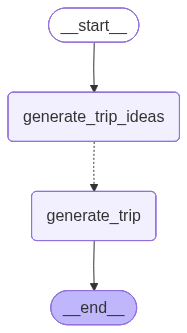

In [16]:

model = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

trip_ideas_prompt = f"""You are an NYC travel coordinator.
Generate exactly 3 distinct trip ideas for a {{trip_type}} visiting New York City for {{days}} day(s).
Return short, title-like ideas (4–7 words each)."""

trip_generation_prompt = f"""You are an NYC travel coordinator.
Write a concise plan for the idea "{{idea}}" in New York City tailored to a {{trip_type}}.
Format:
- Morning — … (nearest subway)
- Afternoon — … (nearest subway)
- Evening — … (nearest subway)
Keep it tight (< 90 words)."""



class TripIdeas(BaseModel):
    ideas: list[str]

class Trip(BaseModel):
    plan: str

class OverallState(TypedDict):
    trip_type: str            # e.g., "family", "couple", "solo"
    days: int                 # e.g., 2
    trip_ideas: list          # filled by generate_trip_ideas
    trips: Annotated[list, operator.add]  # accumulator

class TripState(TypedDict):
    idea: str
    trip_type: str

def generate_trip_ideas(state: OverallState):
    prompt = trip_ideas_prompt.format(trip_type=state["trip_type"], days=state["days"])
    resp = model.with_structured_output(TripIdeas).invoke(prompt)
    return {"trip_ideas": resp.ideas}

def generate_trip(state: TripState):
    prompt = trip_generation_prompt.format(idea=state["idea"], trip_type=state["trip_type"])
    resp = model.with_structured_output(Trip).invoke(prompt)
    return {"trips": [f"{state['idea']}\n{resp.plan}"]}
    

def continue_to_trips(state: OverallState):
    return [Send("generate_trip", {"idea": idea, "trip_type": state["trip_type"]})
            for idea in state["trip_ideas"]]



graph = StateGraph(OverallState)
graph.add_node("generate_trip_ideas", generate_trip_ideas)
graph.add_node("generate_trip", generate_trip)

graph.add_edge(START, "generate_trip_ideas")
graph.add_conditional_edges("generate_trip_ideas", continue_to_trips, ["generate_trip"])
graph.add_edge("generate_trip", END)   # each branch ends; 'trips' accumulates

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))    

You provide the initial state, then `app.stream(inputs)` emits updates as each node runs:  
- First the 3 generated ideas  
- Then each trip plan as it's produced  

Printing each update lets you watch the graph fill `trip_ideas` and accumulate `trips` in real time.


In [17]:
inputs = {"trip_type": "family", "days": 2, "trip_ideas": [], "trips": []}
for update in app.stream(inputs):
    print(update)


c:\Users\ryanb\coding_projects\easy_langgraph\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:1949: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo-0125 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


{'generate_trip_ideas': {'trip_ideas': ['Central Park Picnic Adventure', 'Broadway Show Extravaganza', 'Empire State Building Sunset Tour']}}


c:\Users\ryanb\coding_projects\easy_langgraph\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:1949: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo-0125 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(
c:\Users\ryanb\coding_projects\easy_langgraph\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:1949: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo-0125 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(
c:\Users\ryanb\coding_projects\easy_langgraph\.venv\Lib\site-pac

{'generate_trip': {'trips': ['Central Park Picnic Adventure\nCentral Park Picnic Adventure for a family in NYC: Morning—Start at Bethesda Terrace for a scenic walk. Afternoon—Enjoy a picnic at Sheep Meadow. Evening—Visit the Central Park Zoo. Nearest subway: 59th St-Columbus Circle.']}}
{'generate_trip': {'trips': ['Empire State Building Sunset Tour\nMorning — Start the day with a visit to Central Park, perfect for family strolls. Nearest subway: 59th St-Columbus Circle. Afternoon — Explore Times Square for shopping and entertainment. Nearest subway: Times Square-42nd St. Evening — Enjoy a sunset tour of the Empire State Building for breathtaking views. Nearest subway: 34th St-Herald Square.']}}
{'generate_trip': {'trips': ["Broadway Show Extravaganza\nMorning — Start the day with a visit to Central Park, enjoy a picnic at Sheep Meadow. Nearest subway: 59th St-Columbus Circle. Afternoon — Explore Times Square, visit M&M's World and Toys 'R' Us. Nearest subway: Times Square-42nd St. Eve